In [1]:
import os
import re
from IPython.display import clear_output
from matplotlib import pyplot as plt
import numpy as np
import pandas as pd
# from oneibl.onelight import ONE # only used for downloading data
# import wget
from utils import *
from plotting_utils import *
from analysis_utils import *
import dglm_hmm1
from pandas.errors import SettingWithCopyWarning
warnings.simplefilter(action="ignore", category=SettingWithCopyWarning)


ibl_data_path = '../data_IBL'
dfAll = pd.read_csv(ibl_data_path + '/Ibl_processed.csv')
subjectsWitten = np.unique(dfAll[dfAll['lab'] == 'wittenlab']['subject']).tolist()
colorsFeatures = [['#FAA61A','indigo','#99CC66','#59C3C3','#9593D9'],['#FAA61A',"#2369BD","#A9373B",'#99CC66','#59C3C3','#9593D9']]
colorsStates = ['darkblue','forestgreen','darkorange','purple']
myFeatures = [['bias','delta stimulus', 'previous choice', 'previous answer'],['bias','contrast left','contrast right', 'previous choice', 'previous answer']]
sns.set_context("talk")
colormap = ['rebeccapurple','teal','darkturquoise','springgreen','gold']

In [2]:
alphaList = [2*(10**x) for x in list(np.arange(-1,6,0.5,dtype=float))]
L2penaltyW = 1
maxiter = 200
bestSigma = 1 # verified from fitting multiple sigmas
priorDirP = None
fit_init_states = False
splitFolds = 5

D = 4 # number of features
sessStop = -1 # last session to use in fitting

# ignore animals 02 and 03
# MISSING ANIMALS 05 AND 07 FOR K=3
dfAll = pd.read_csv(ibl_data_path + '/Ibl_processed.csv')
subjectsWitten = np.unique(dfAll[dfAll['lab'] == 'wittenlab']['subject']).tolist()
subjectsWitten.remove('ibl_witten_02')
subjectsWitten.remove('ibl_witten_03')
subjectsWitten.remove('ibl_witten_05')
subjectsWitten.remove('ibl_witten_07')
print(subjectsWitten)

['ibl_witten_04', 'ibl_witten_06', 'ibl_witten_12', 'ibl_witten_13', 'ibl_witten_14', 'ibl_witten_15', 'ibl_witten_16']


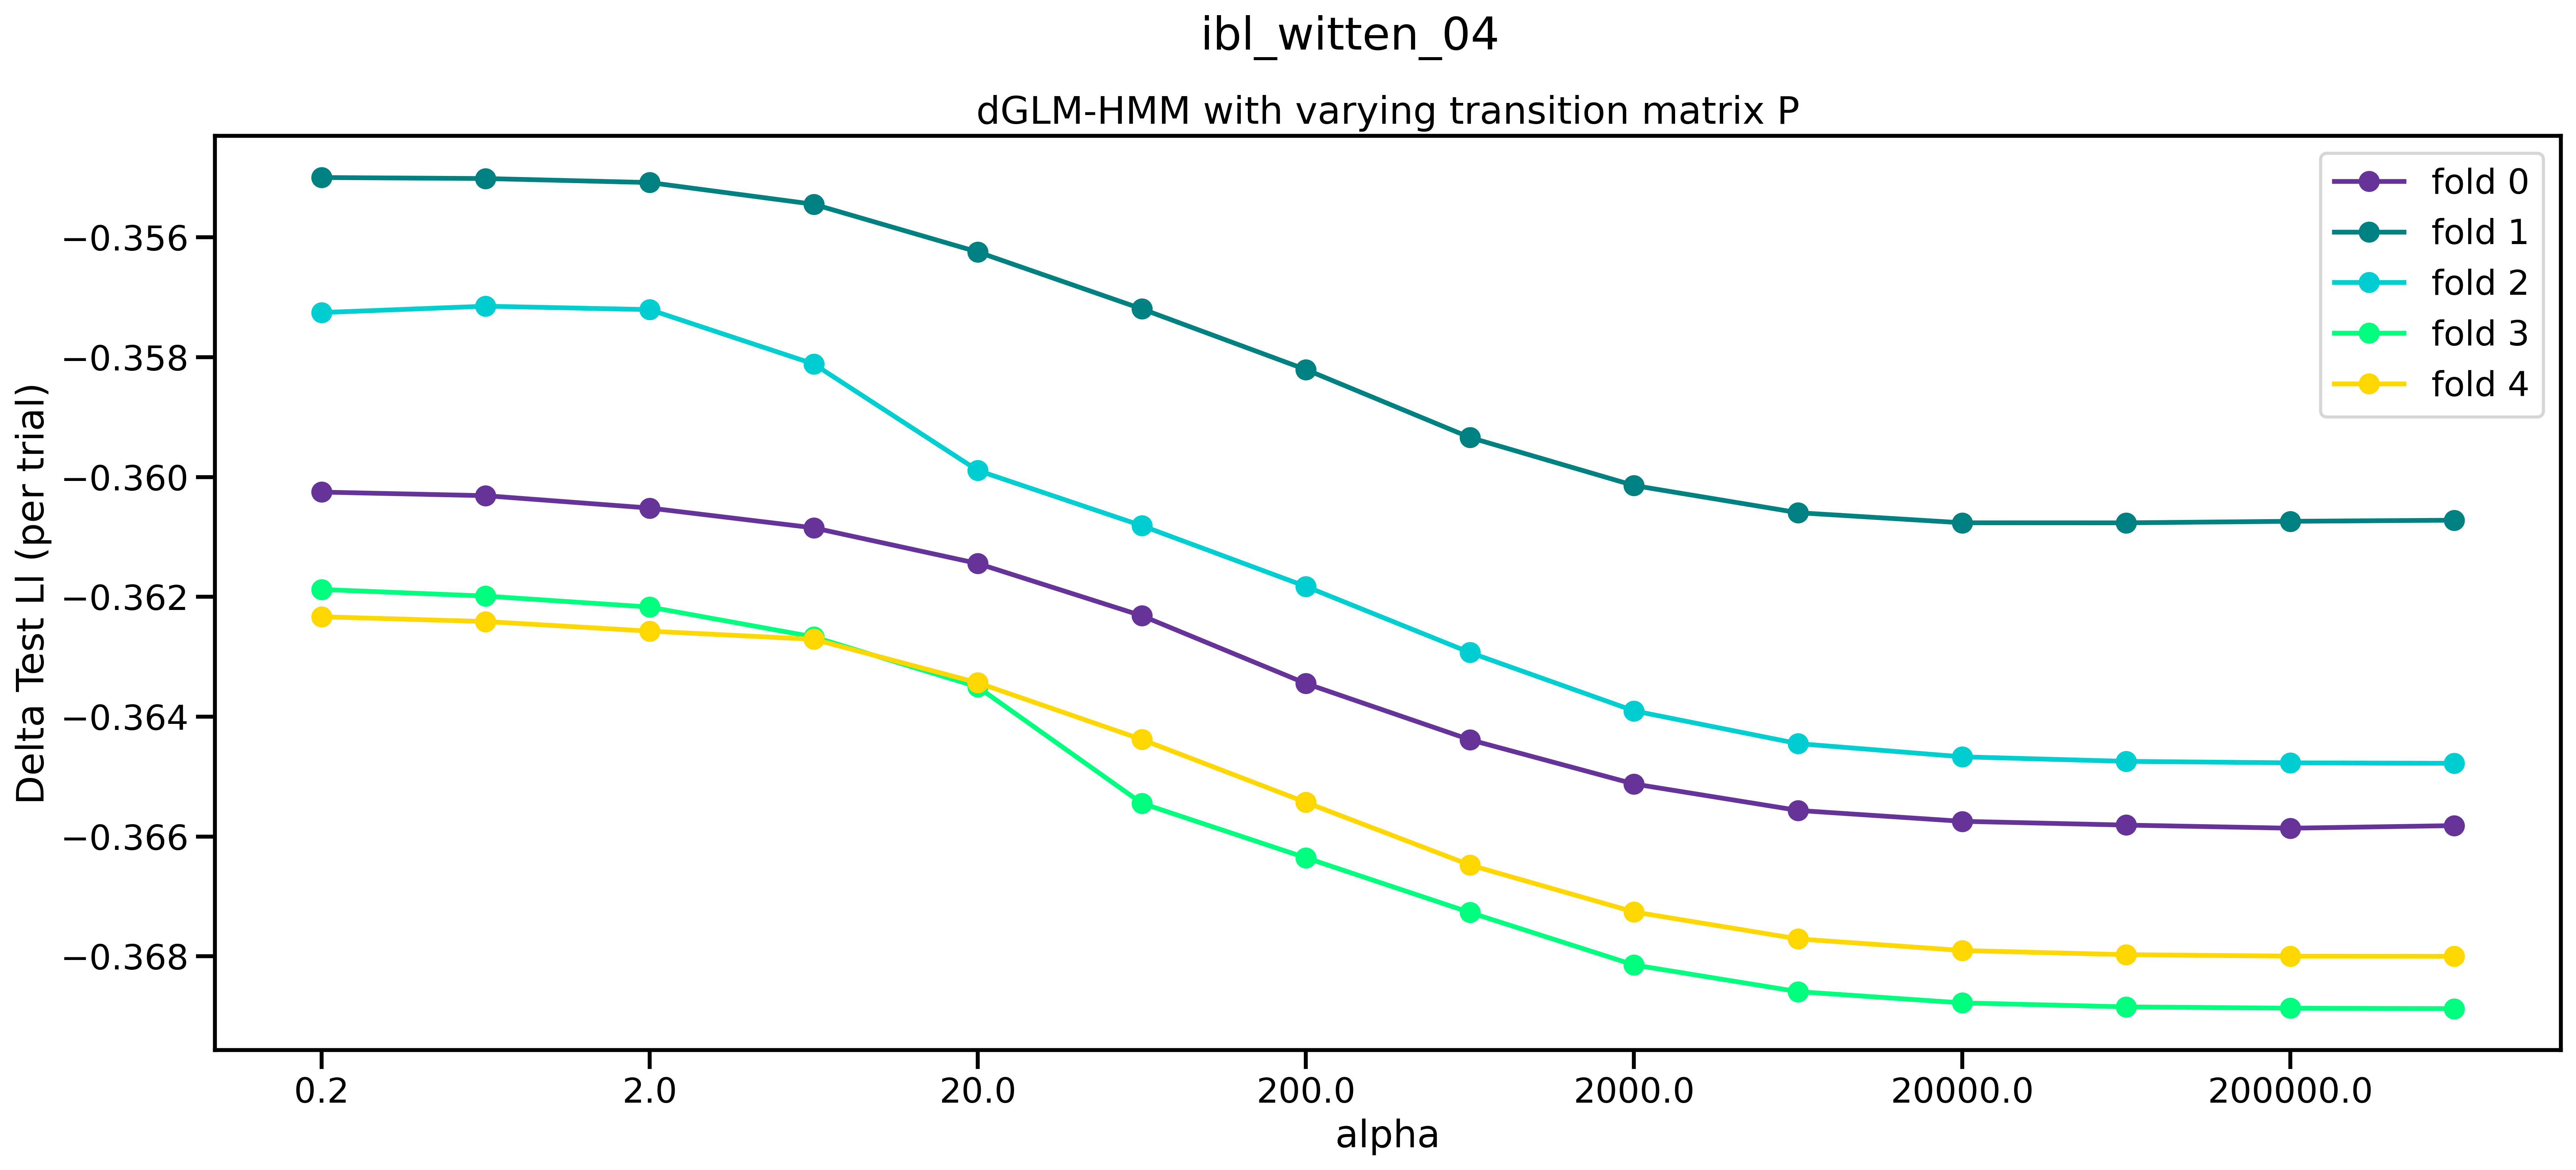

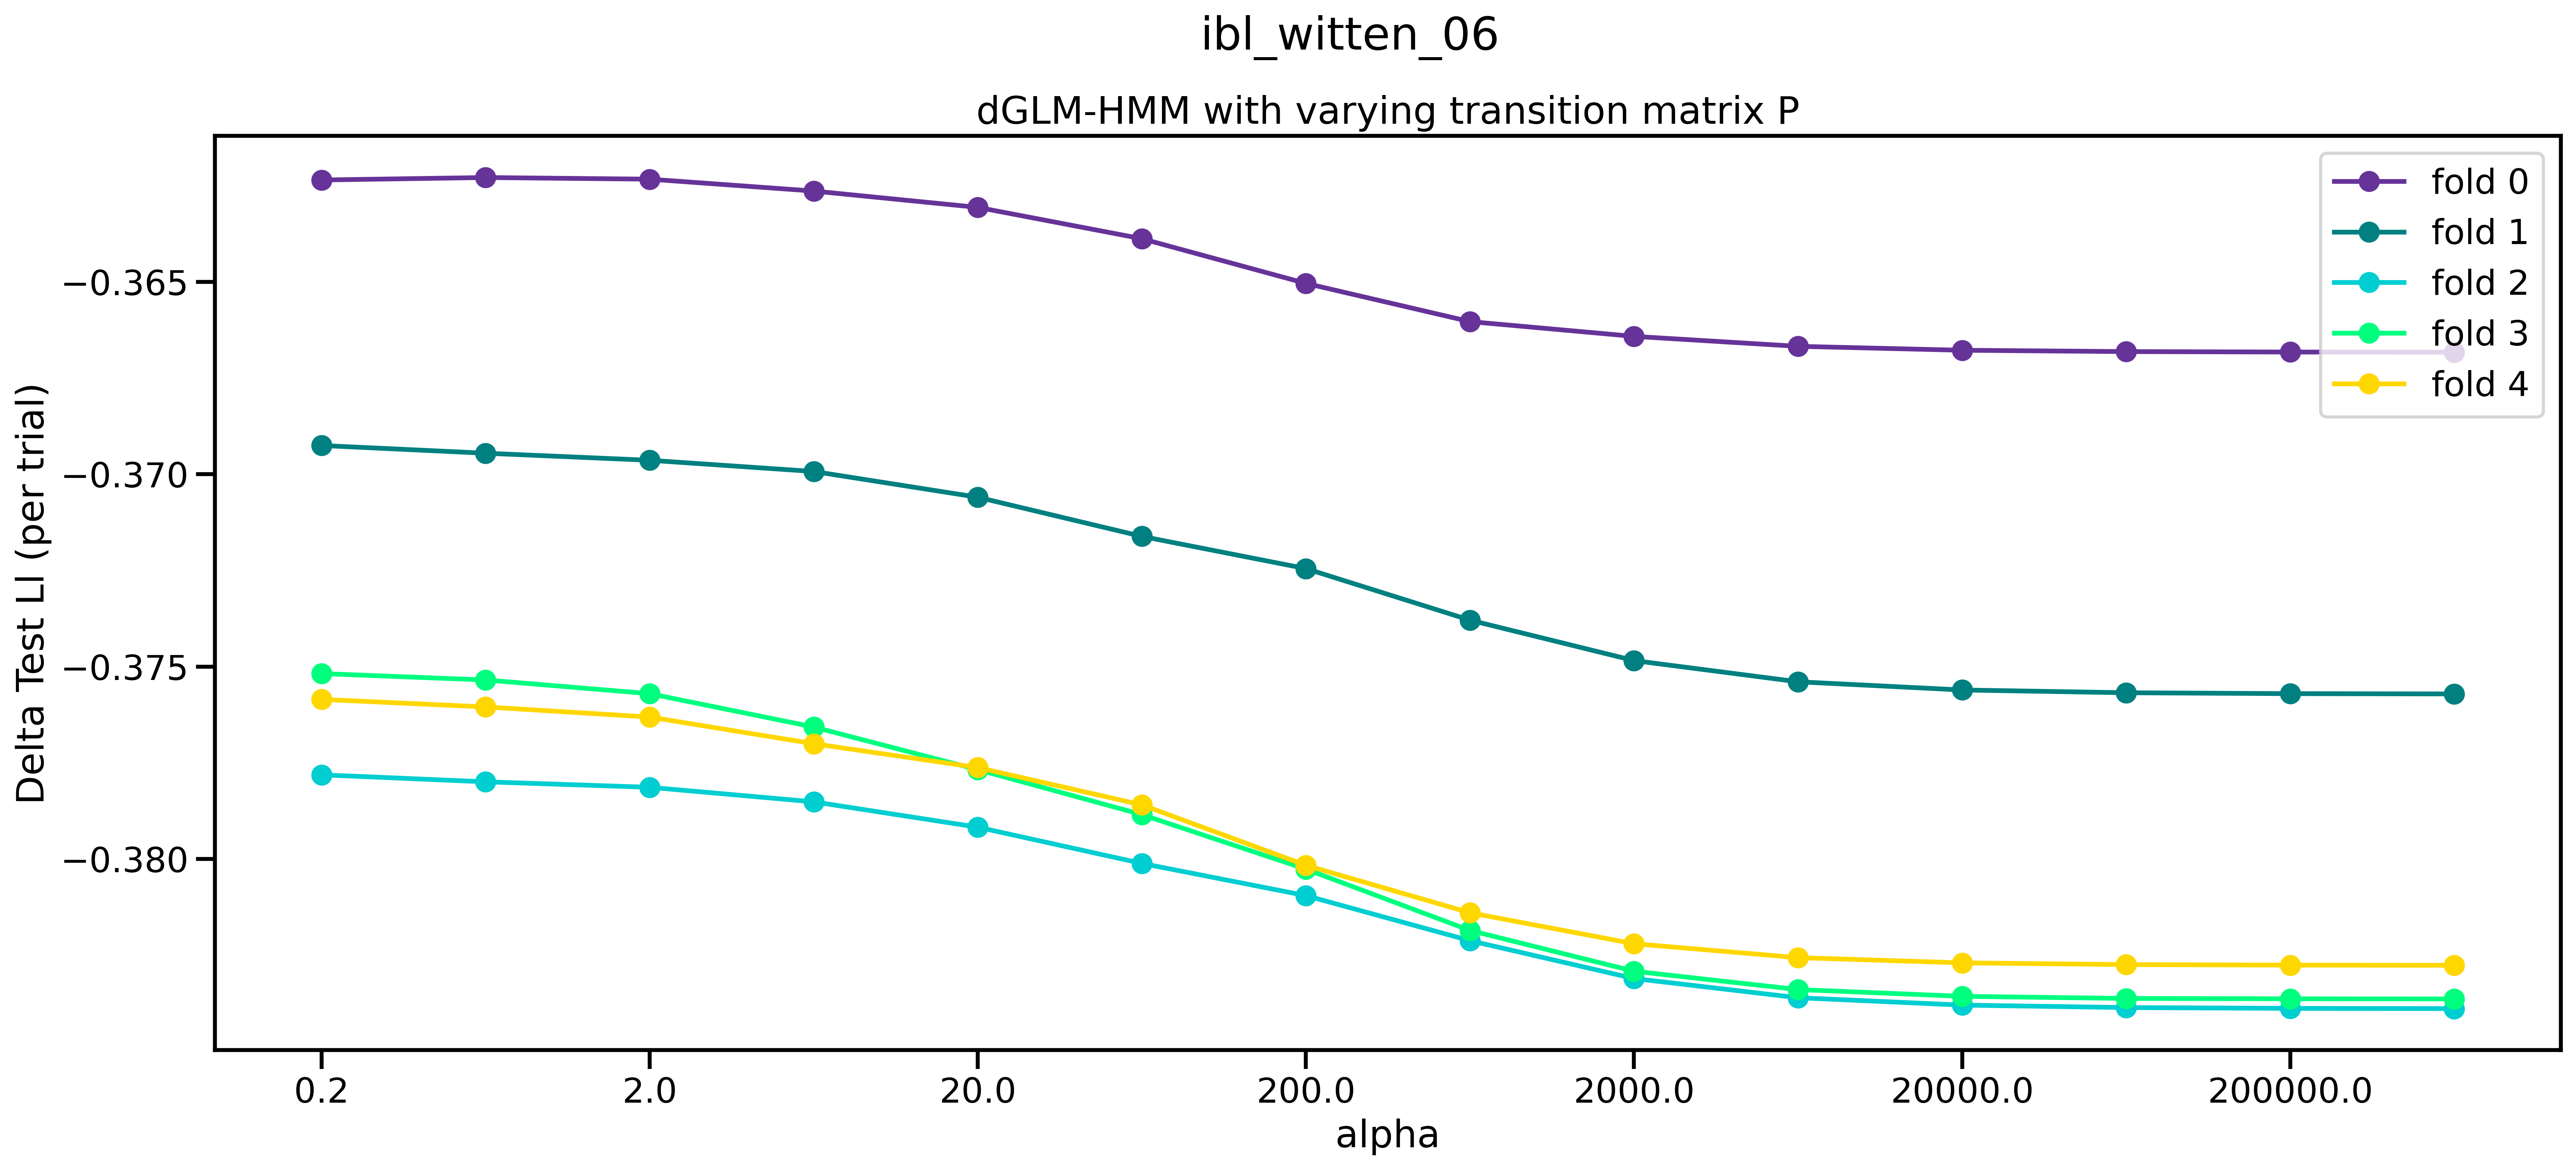

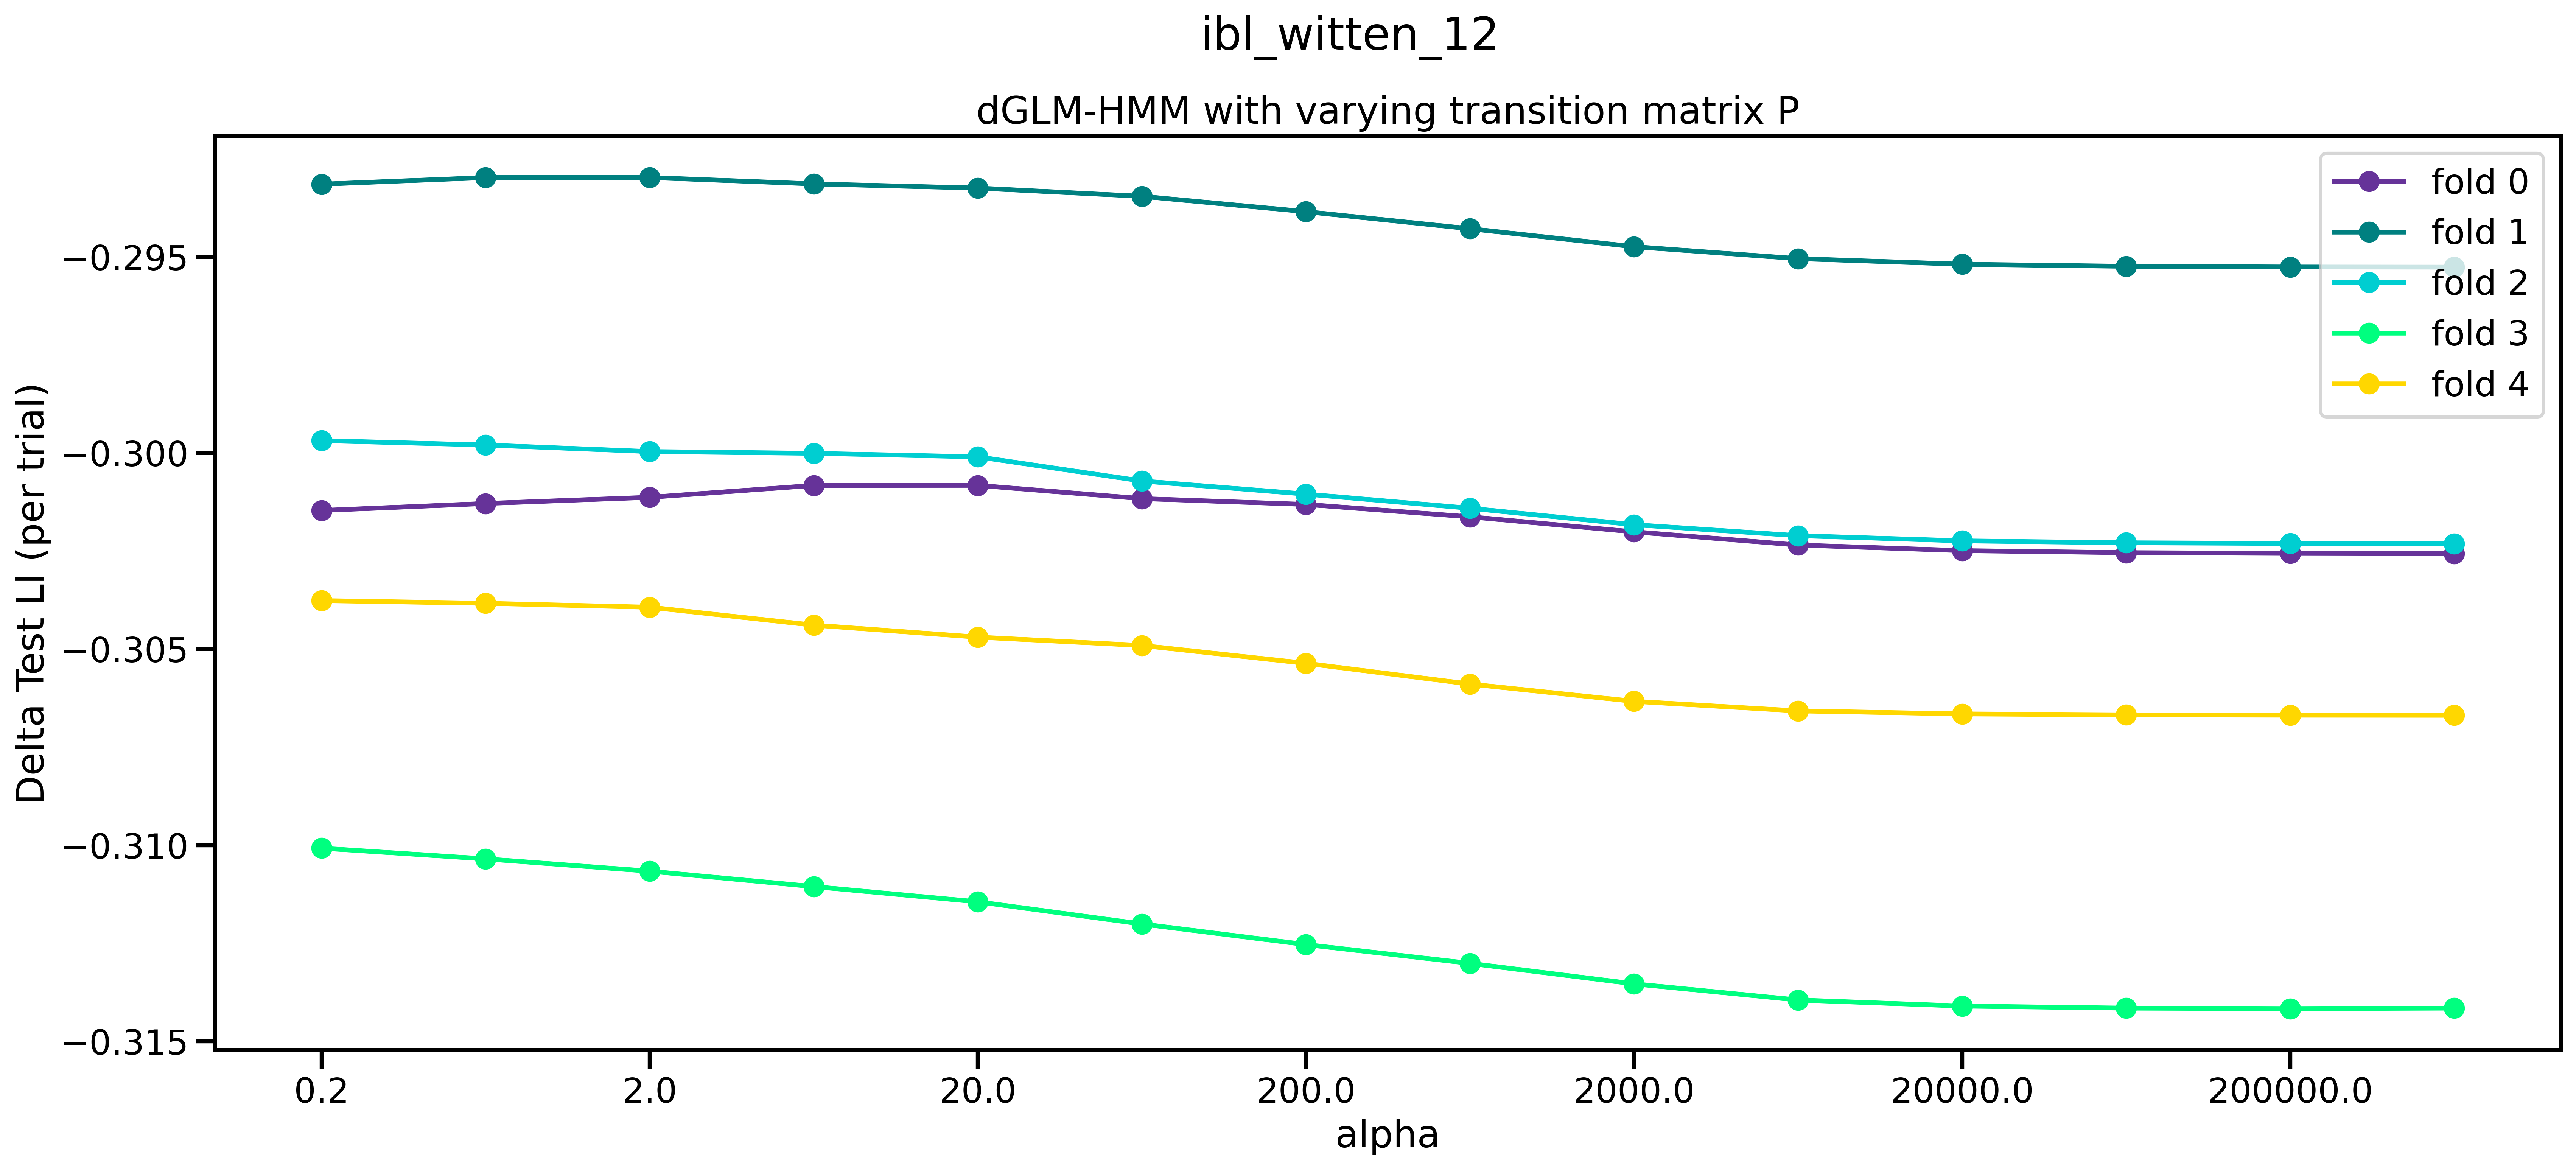

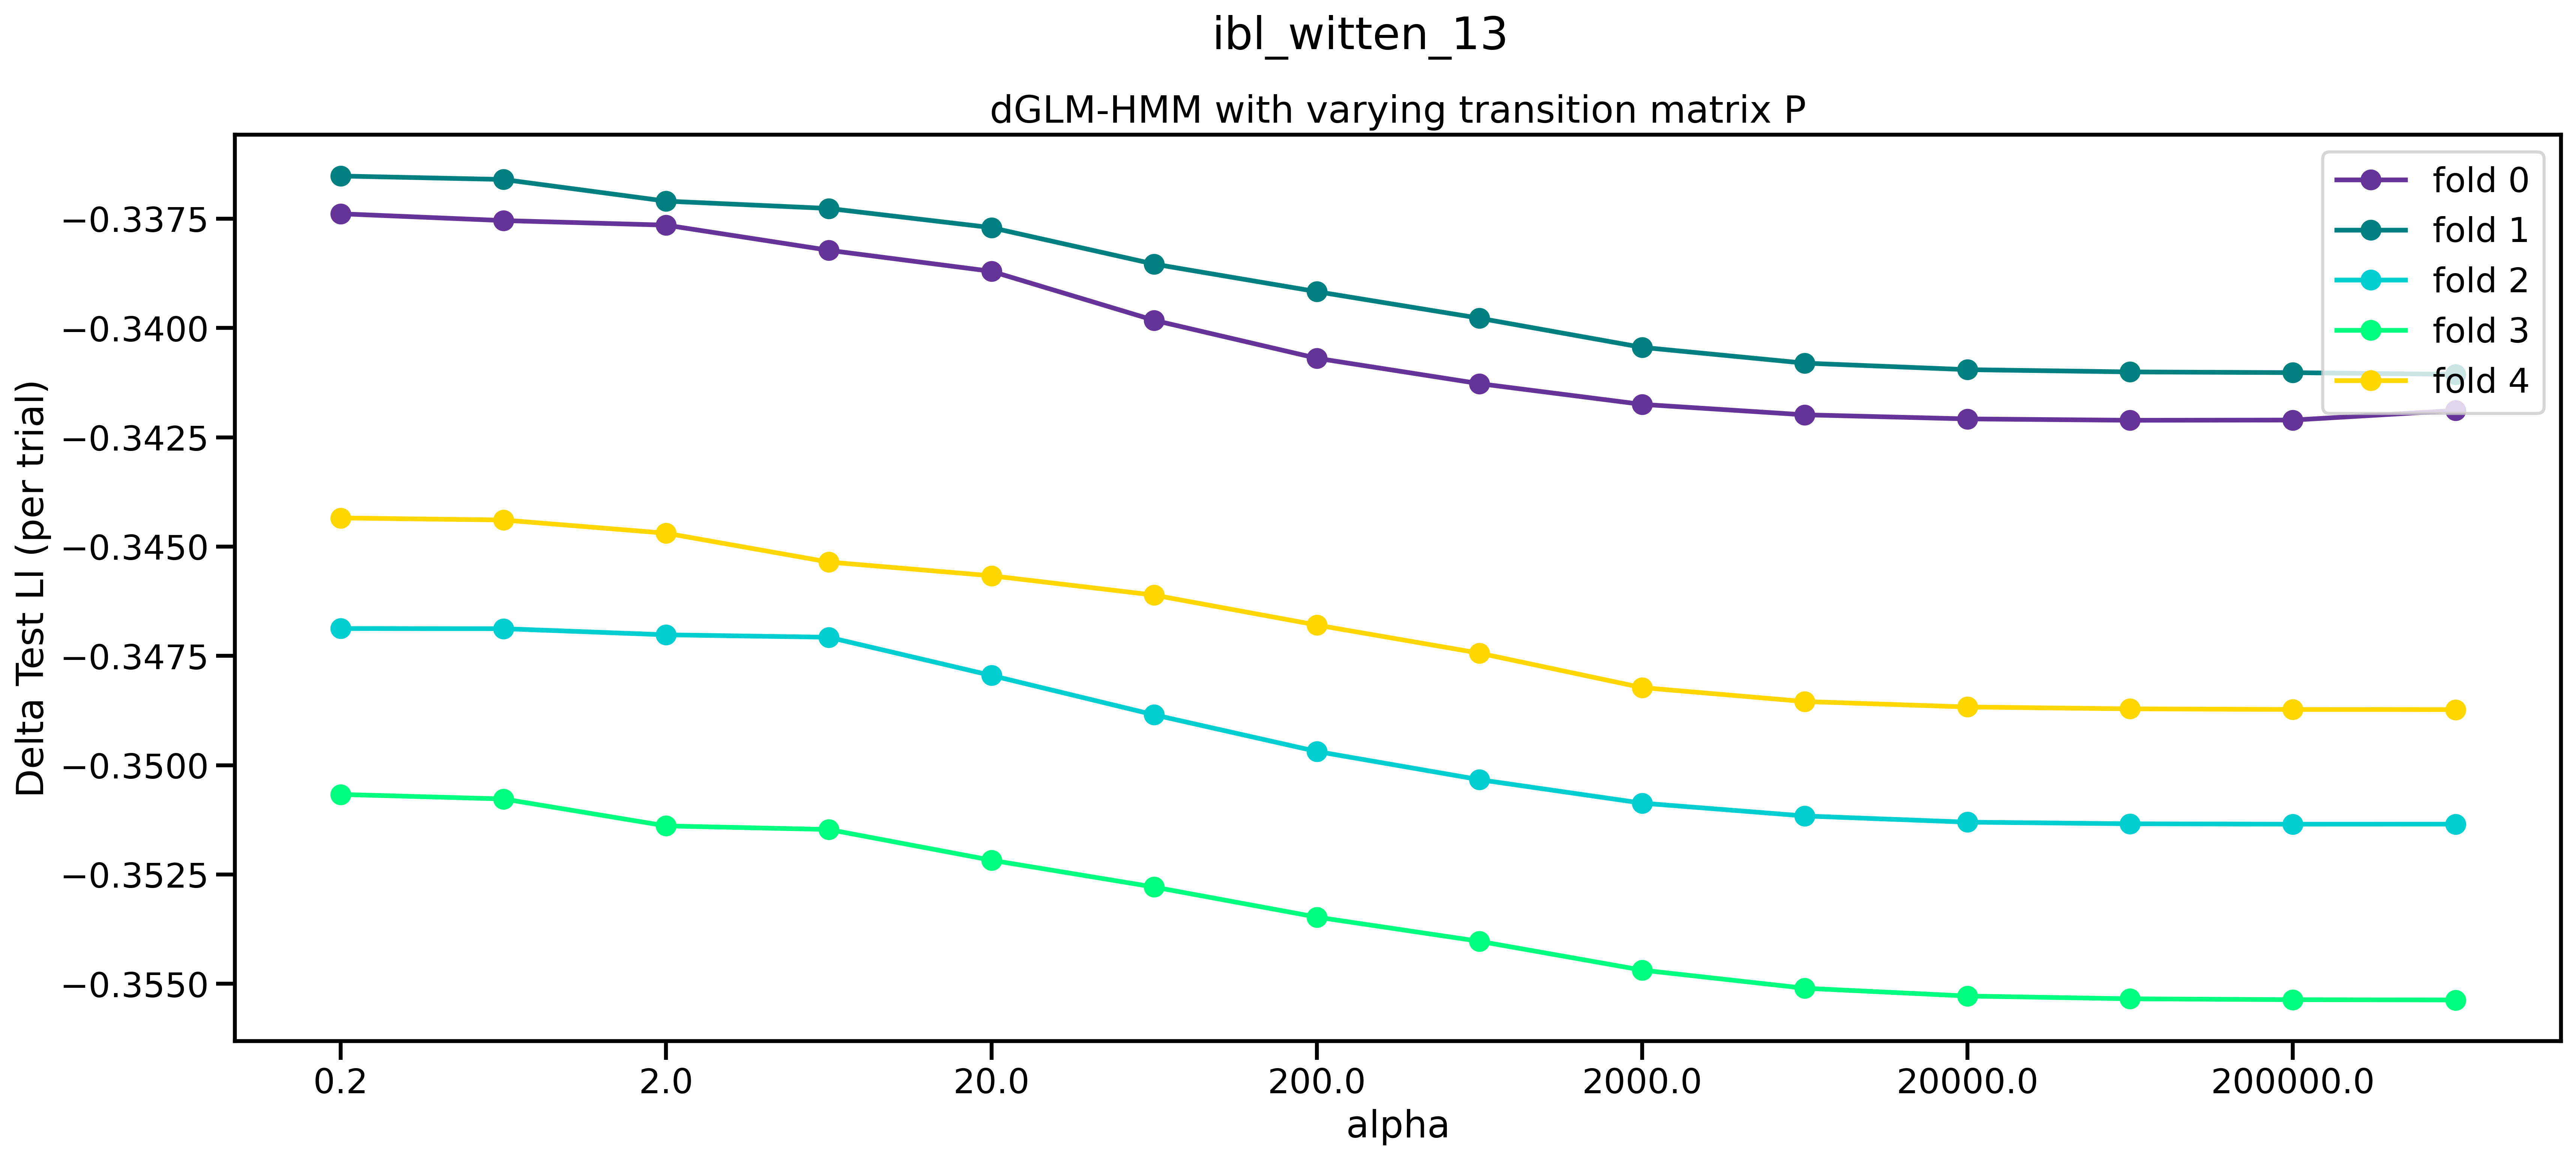

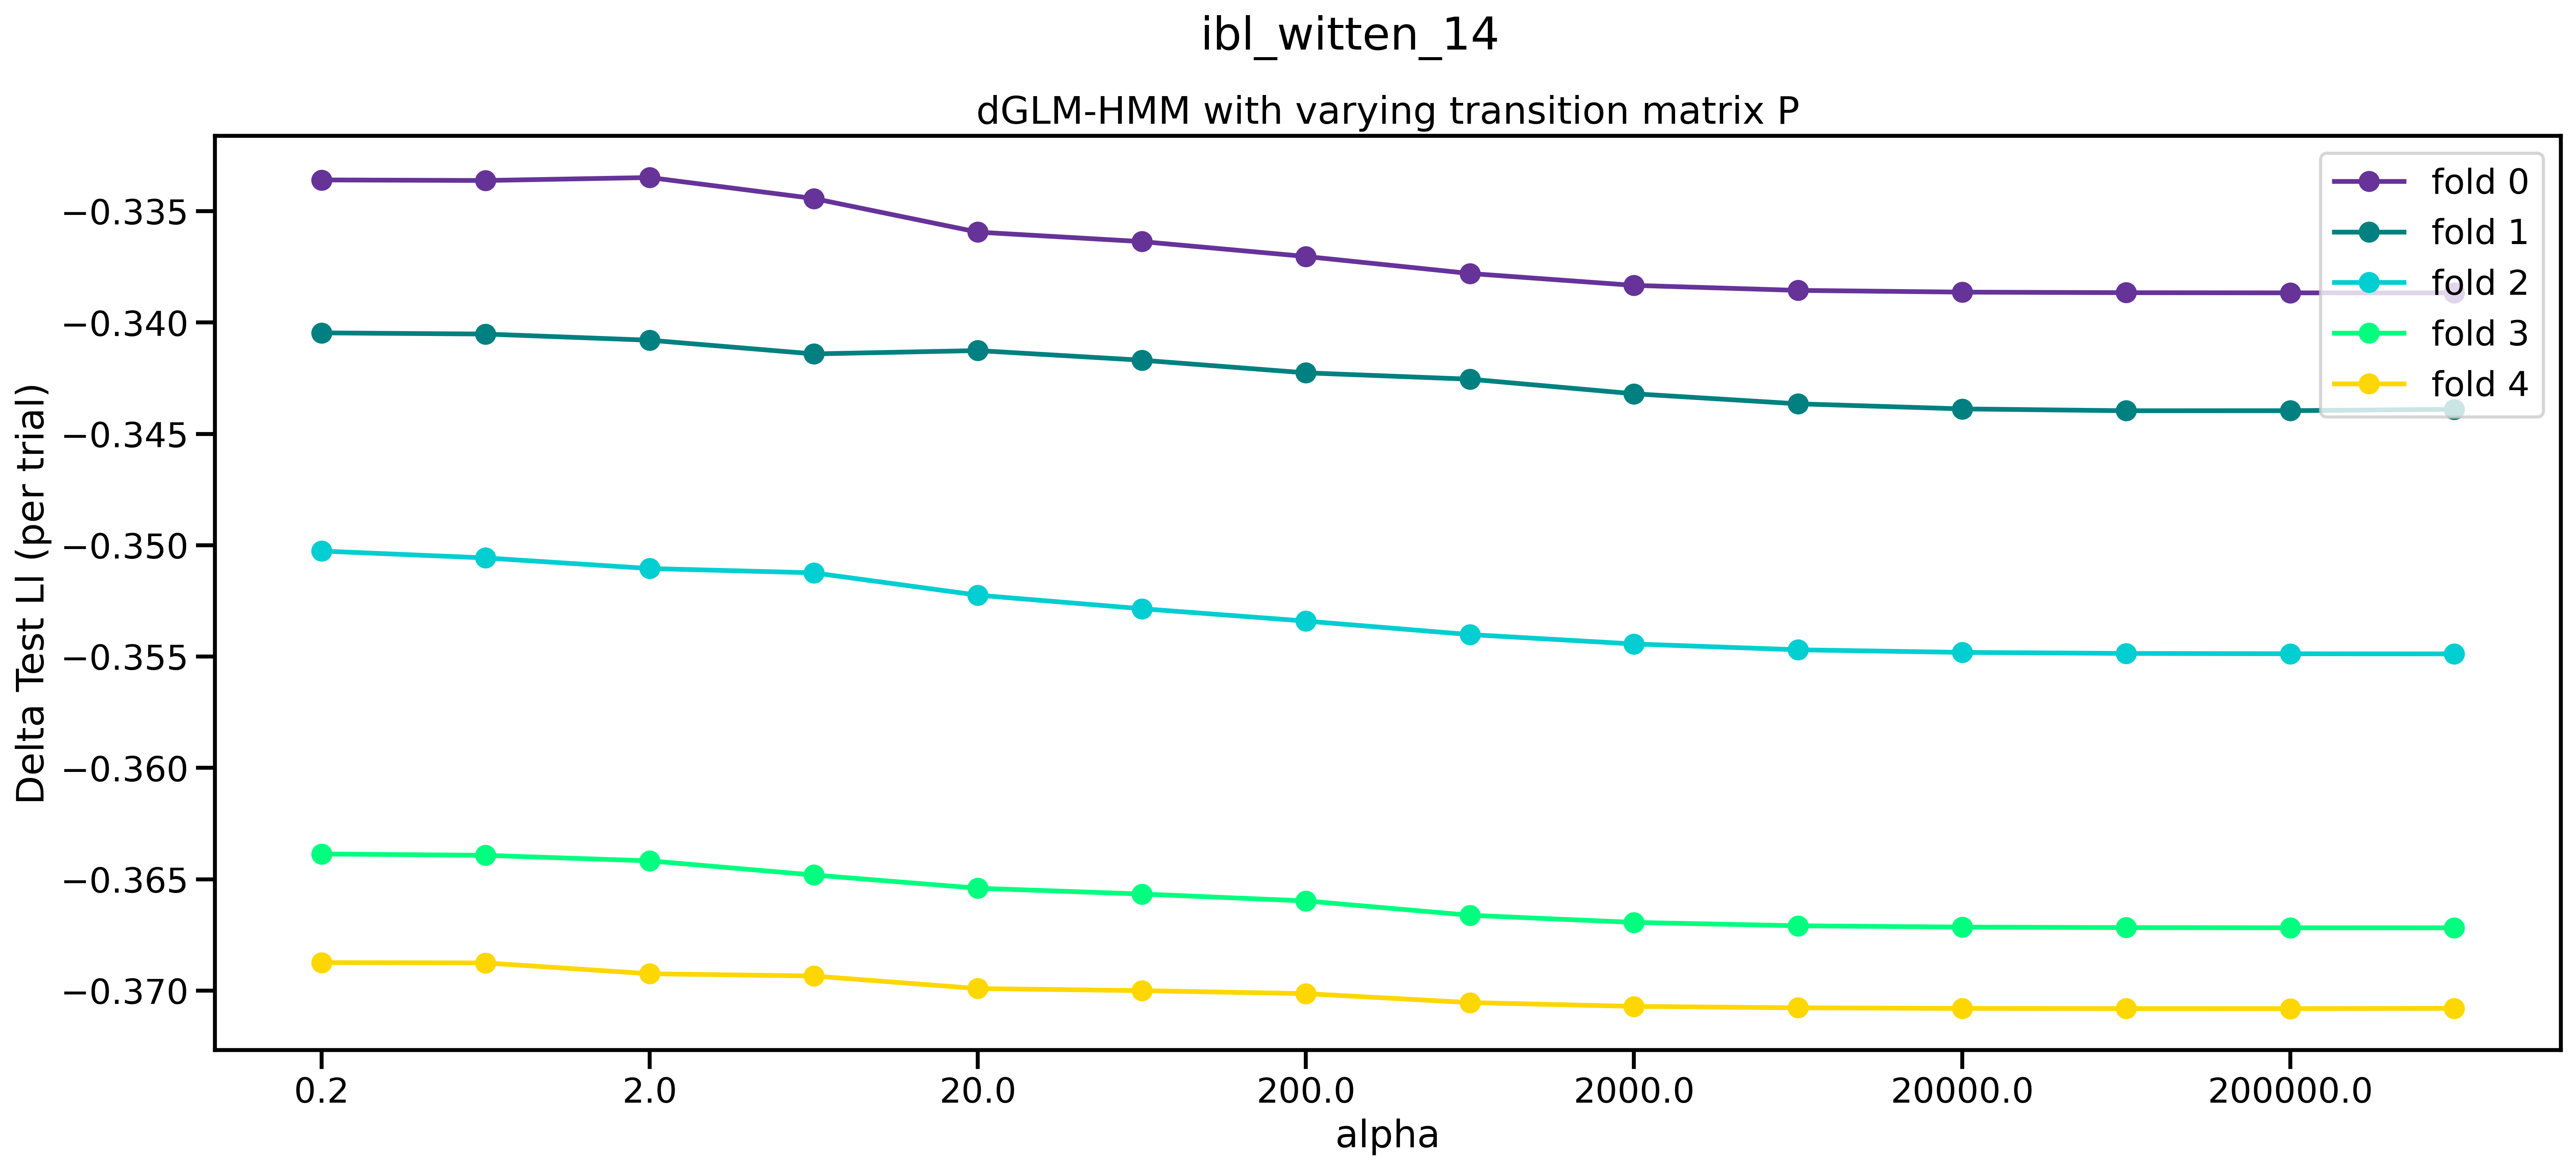

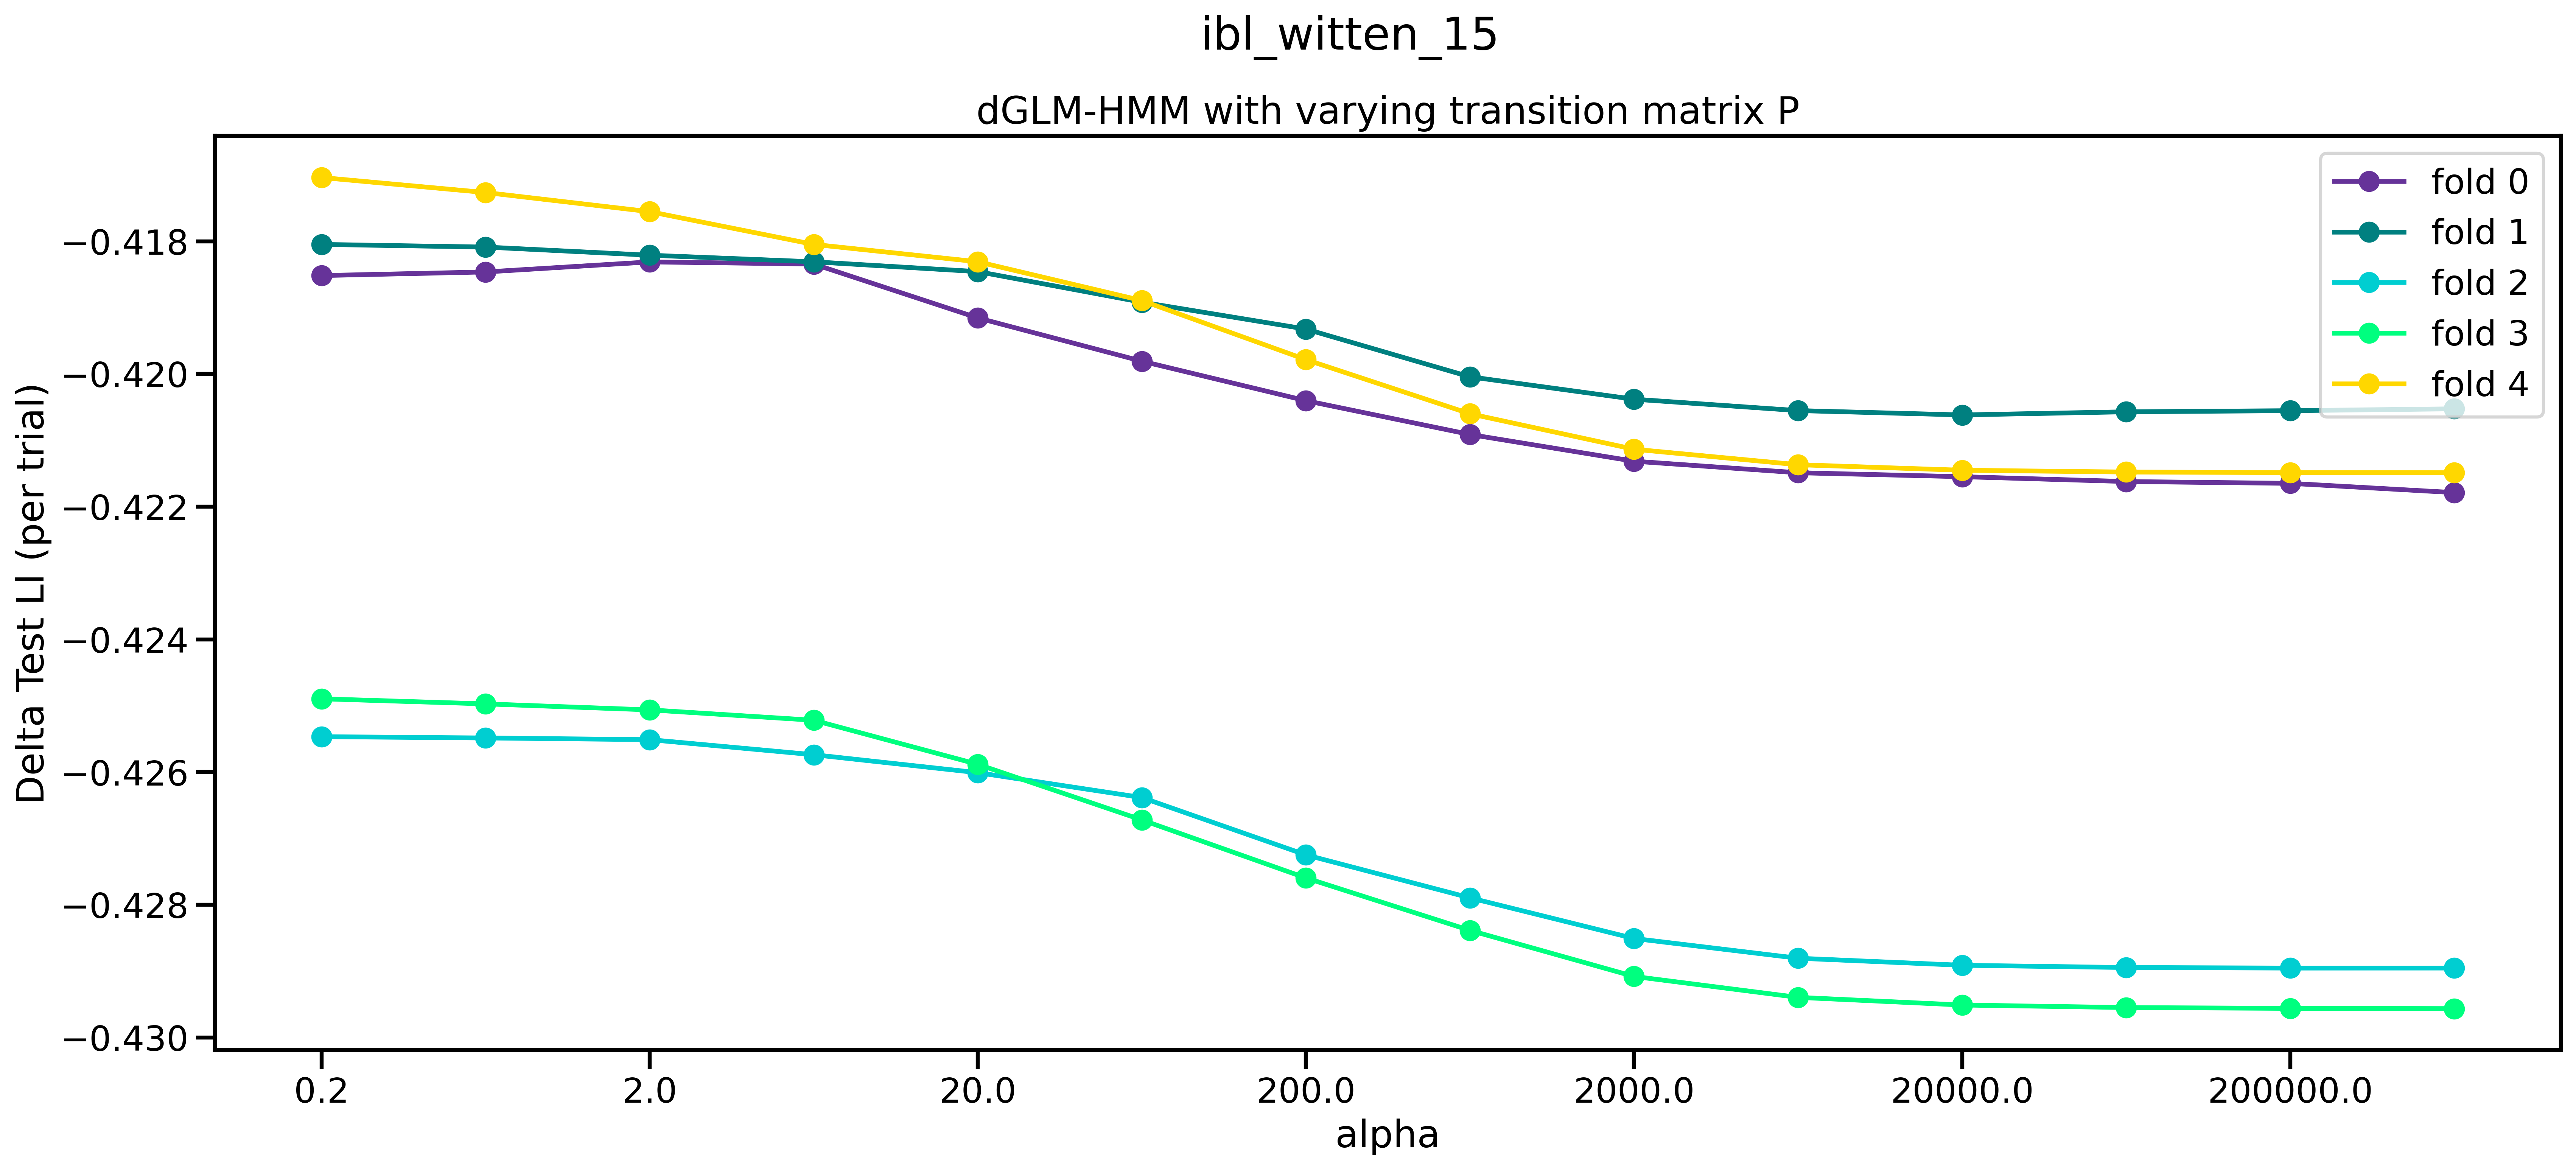

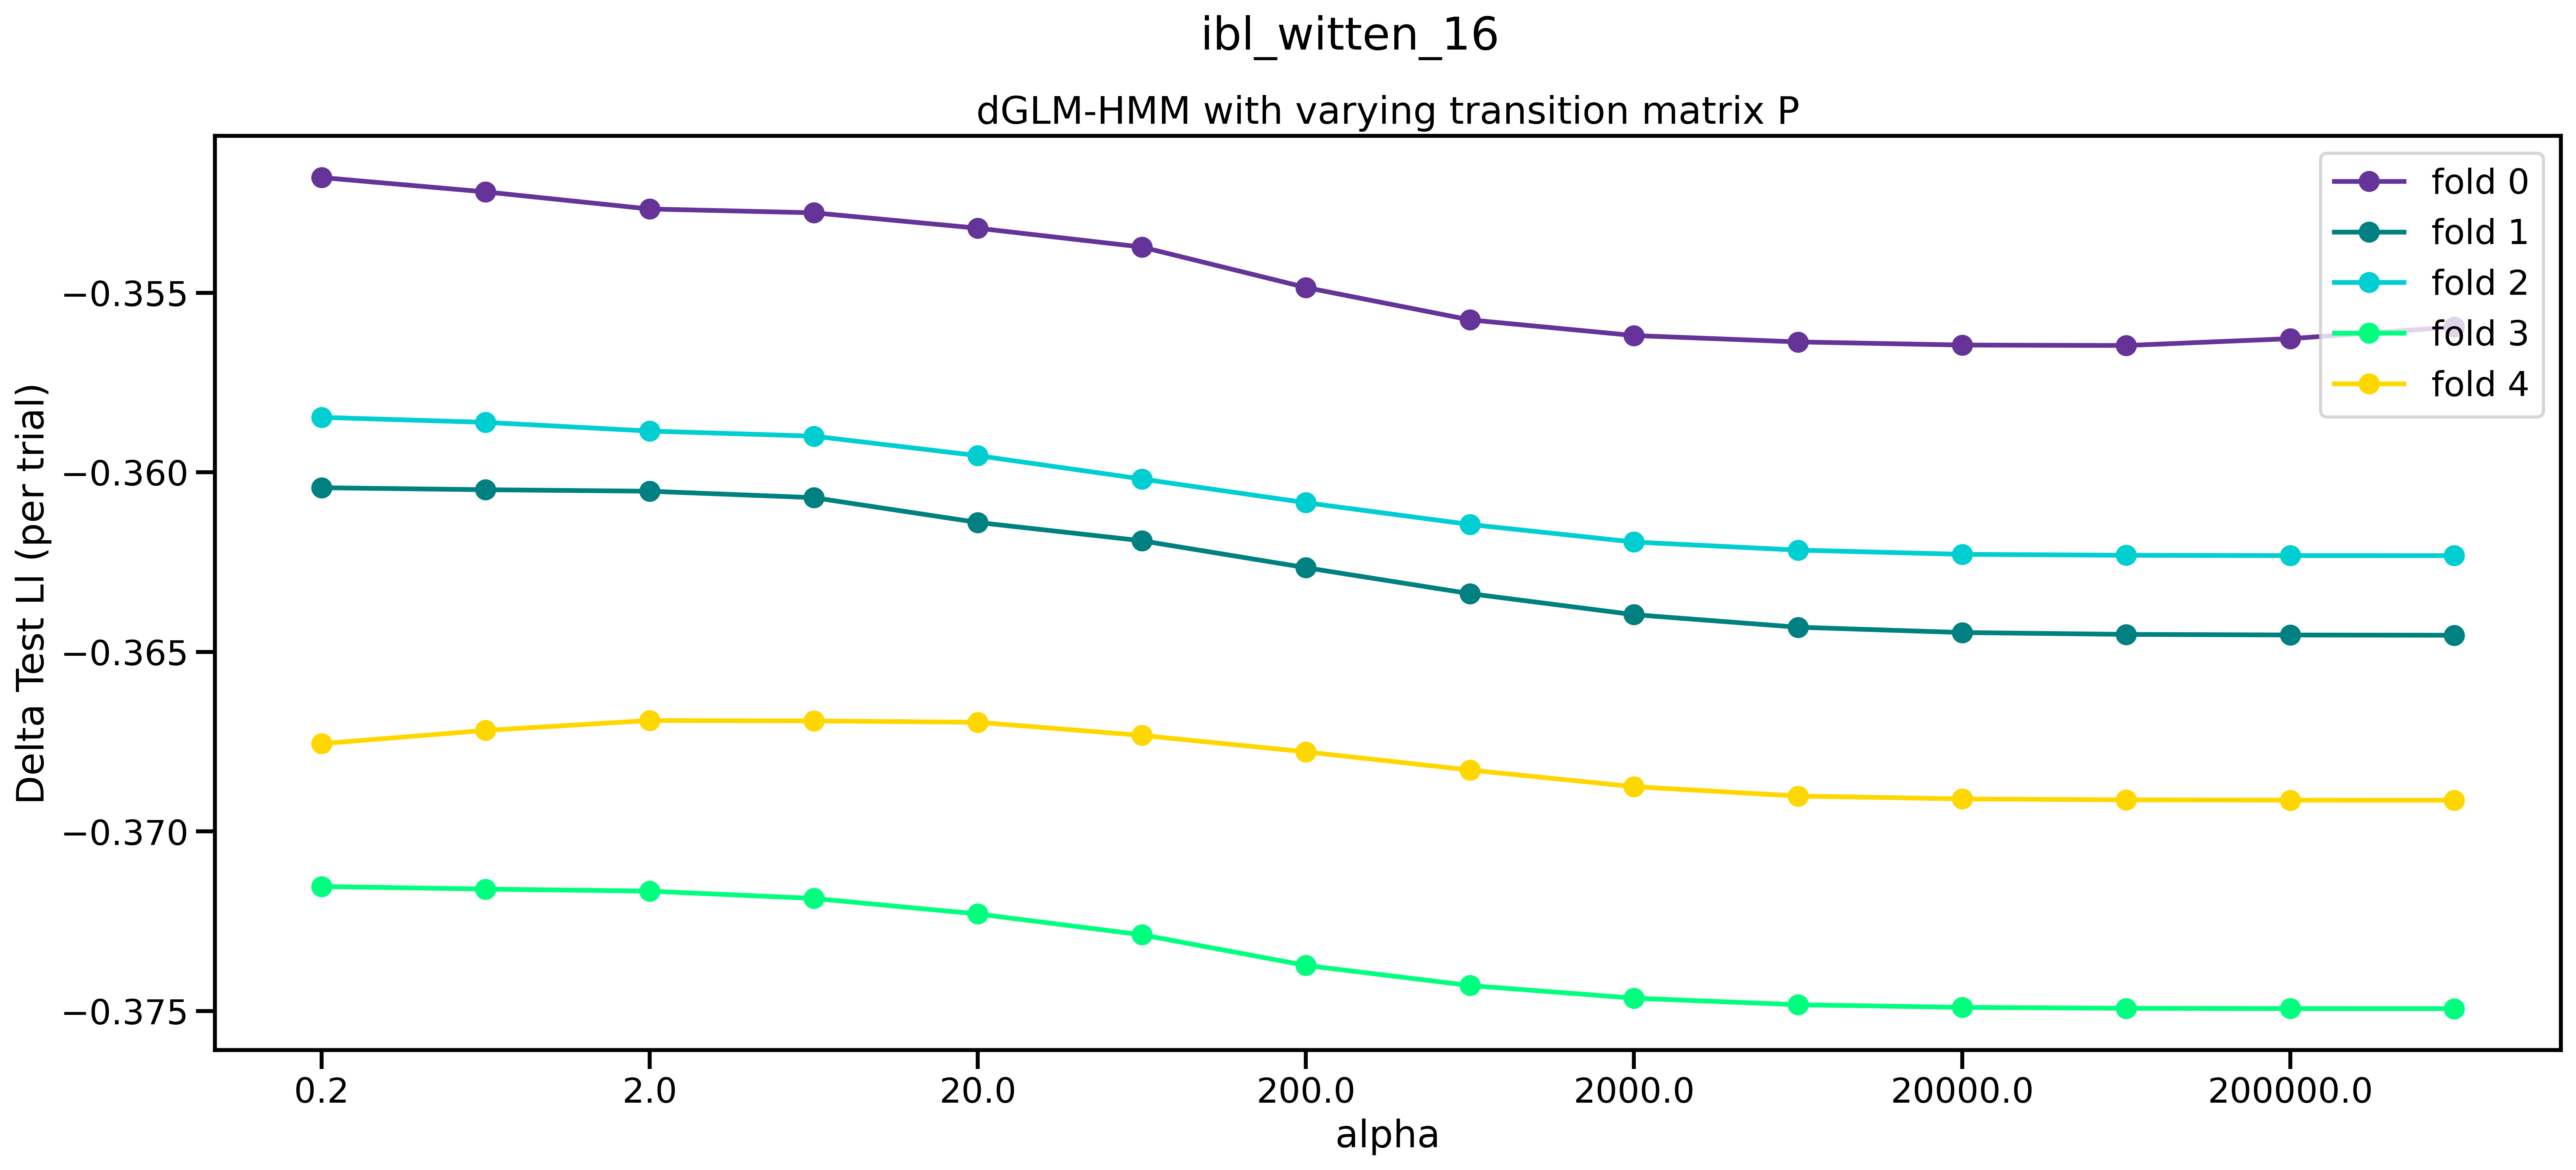

In [3]:
# Checking variability in TestLl across folds
for idx in range(0, len(subjectsWitten)):
    subject = subjectsWitten[idx]
    testLl = []
    testAccuracy = []
    avgTestLl = []
    avgTestAccuracy = []

    for K in [3]: 
        fig, axes = plt.subplots(1,figsize=(20,8), dpi=400)
        fig.suptitle(subject)
        for fold in range(0, splitFolds):
            testLl.append(np.load(f'../data_IBL/{subject}/{subject}_testLl_D={D}_{K}_state_fold-{fold}_alphas_L2penaltyW={L2penaltyW}_untilSession{sessStop}.npy'))
            testAccuracy.append(np.load(f'../data_IBL/{subject}/{subject}_testAccuracy_D={D}_{K}_state_fold-{fold}_alphas_L2penaltyW={L2penaltyW}_untilSession{sessStop}.npy'))
            # axes.scatter(np.log10(alphaList[-1])+1, testLl[fold][-1], label='', color='black')
            plot_testLl_CV_alpha(testLl[fold], alphaList, label=f'fold {fold}', color=colormap[fold], axes=axes, linestyle='-o', alpha=1)
            axes.set_ylabel("Delta Test Ll (per trial)")

        avgTestLl.append(np.mean(testLl[:],axis=0))
        avgTestAccuracy.append(np.mean(testAccuracy[:],axis=0))
    avgTestLl = [x - avgTestLl[-1][0] for x in avgTestLl] # normalizing to dGLM-HMM1 K=1
    avgTestAccuracy = [x - avgTestAccuracy[0][0] for x in avgTestAccuracy]

In [4]:
# CHECKING FOR VARIABILITY ACROSS FOLDS IN TRANSITON MATRIX

bestAlphaInd = 0 # equivalent to sigma=1
Kplot = [1,2,3] # K for which to plot parameters for each animal

allP = np.empty((len(subjectsWitten), 3), dtype=object)

for idx in range(0, len(subjectsWitten)):
    subject=subjectsWitten[idx]
    _, _, sessInd, correctSide = get_mouse_design(dfAll, subject, sessStop=sessStop, D=D)

    for K in [3]:

        tempW = []
        tempP = []
        for fold in range(0, splitFolds):

            tempP.append(np.load(f'../data_IBL/{subject}/{subject}_P_D={D}_{K}_state_fold-{fold}_alphas_L2penaltyW={L2penaltyW}_untilSession{sessStop}.npy'))
            tempW.append(np.load(f'../data_IBL/{subject}/{subject}_W_D={D}_{K}_state_fold-{fold}_alphas_L2penaltyW={L2penaltyW}_untilSession{sessStop}.npy'))

        sess = len(sessInd)-1
        for i in range(0,K):
            fig, axes = plt.subplots(1, figsize = (20,5), dpi=400)
            axes.set_title(f'State {i+1} - {subject}')
            axes.set_xlim(0,30)
            axes.set_xticks(range(1,30))
            axes.grid(axis='x', zorder=0)
            for fold in range(0, splitFolds):
                axes.scatter(range(1,sess+1),tempP[fold][bestAlphaInd][sessInd[:-1],i,i], color=colormap[fold], label=f'fold {fold}', zorder=splitFolds-fold)
            axes.set_xlabel('sessions')
            axes.set_ylabel('self-transition probabilities')
            axes.legend()
            axes.set_ylim(0,1)